In [ ]:
# -*- coding: utf-8 -*-

"""
    @author: Ethan Poole 
"""

In [29]:
# imports
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import scipy
import math
import scipy.optimize as optimization
from PIL import Image 
import PIL
from numpy import diff
from scipy.signal import savgol_filter
import lmfit
from lmfit import Model

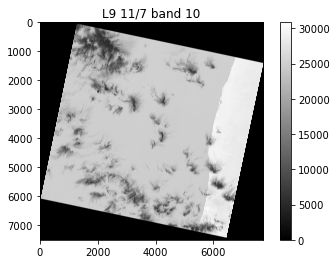

In [68]:
# upload image
path = 'on/LC09_L1TP_186038_20211107_20211107_02_T1/'
im = 'LC09_L1TP_186038_20211107_20211107_02_T1_B10.TIF'
imname = 'L9 11/7 band 10'
output = 'l9_11_09_062170_b10/'
image = Image.open(path+im)
imarray = np.array(image)
temp_im = imarray #(imarray*0.00341802+149)-273.15 converts to temp
low_values_flags = temp_im < 0  # Where values are low
temp_im[low_values_flags] = 0 
temp_im = temp_im.astype(np.float)

temp_im = np.rot90(temp_im)

f = plt.figure()
plt.imshow(temp_im,cmap='gray')
plt.colorbar()
plt.title(imname)
plt.savefig(output+'fullimage.png', dpi=150)

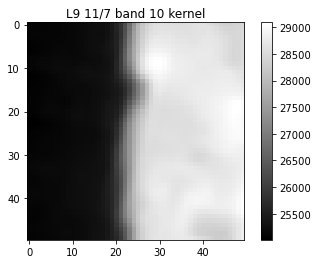

In [69]:
# calculate ROI

# insert rois from find points here
roi = [[6270, 2404]]

dark_roi = [[15,14]]
light_roi = [[40,25]]

cent = roi[0]
x_cent = cent[0]
y_cent = cent[1]

pad = 25
#kernel = np.genfromtxt('roi.csv', delimiter=',')
kernel = temp_im[y_cent - pad:y_cent + pad, x_cent - pad:x_cent + pad]

f = plt.figure()
plt.imshow(kernel,cmap='gray')
plt.title(imname + ' kernel')
plt.colorbar()
plt.savefig(output+'kernel.png', dpi=150)
#np.savetxt('roi.csv', kernel, delimiter=',')

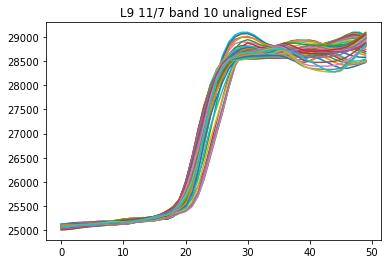

In [70]:
# plot profile for each row
for row in kernel:
    plt.plot(row)
plt.title(imname + ' unaligned ESF')
plt.savefig(output+'esf.png', dpi=150)
plt.show()

In [71]:
# Calculate dark and bright side edge averages

d_cent = dark_roi[0]
dx_cent = d_cent[0]
dy_cent = d_cent[1]

b_cent = light_roi[0]
bx_cent = b_cent[0]
by_cent = b_cent[1]

db_pad = 3

d_kernel = kernel[dy_cent - db_pad:dy_cent + db_pad, dx_cent - db_pad:dx_cent + db_pad]
b_kernel = kernel[by_cent - db_pad:by_cent + db_pad, bx_cent - db_pad:bx_cent + db_pad]

d = np.mean(d_kernel)
b = np.mean(b_kernel)

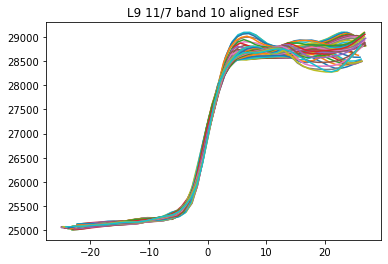

In [72]:
# use modified fermi function to align rows

def fermi_function(b,d,x,s,g,e):
    ans = d + (b-d) / (1 + np.exp(-s * (x - e) )) + (g*x)
    return ans

def residual(params):
    s = params['s']
    e = params['e']
    g = params['g']
    y = fermi_function(b,d,x,s,g,e)
    res = (savgol_filter(row,11, 3) - y)**2  
    return res

x = np.arange(0,50,1)

for row in kernel:
    x0 = np.array([0.0, 0.0, 0.0])
    sigma = np.array(np.ones(len(row)))
    xdata= np.array(list(range(0, len(row))))
    xdata = xdata.astype(np.float64)
    row = row.astype(np.float64)

    params = lmfit.Parameters()
    params.add('s', min=0.1, max=2.0)
    params.add('e', min=-75.0, max=75.0)
    params.add('g', min=0.0, max=14.0)

    mini = lmfit.Minimizer(residual, params, nan_policy='propagate')
    out1 = mini.minimize(method='Nelder')
    out2 = mini.minimize(method='leastsq', params=out1.params)
    p = (out2.params)
    
    e_val = p['e']._val
    curr = e_val
    xdata = xdata- curr
    plt.plot(xdata,row)

plt.title(imname + ' aligned ESF')
plt.savefig(output+'allign_esf.png', dpi=150)
plt.show()

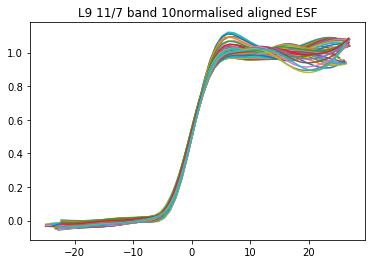

In [73]:
# normalise aligned rows
for row in kernel:
    x0 = np.array([0.0, 0.0, 0.0])
    sigma = np.array(np.ones(len(row)))
    xdata= np.array(list(range(0, len(row))))
    xdata = xdata.astype(np.float64)
    row = row.astype(np.float64)

    def residual(params):
        s = params['s']
        e = params['e']
        g = params['g']
        y = fermi_function(b,d,x,s,g,e)
        res = (savgol_filter(row,11, 3) - y)**2  
        return res

    params = lmfit.Parameters()
    params.add('s', min=0.1, max=2.0)
    params.add('e', min=-75.0, max=75.0)
    params.add('g', min=0.0, max=14.0)

    mini = lmfit.Minimizer(residual, params, nan_policy='propagate')
    out1 = mini.minimize(method='Nelder')
    out2 = mini.minimize(method='leastsq', params=out1.params)
    p = (out2.params)
    
    e_val = p['e']._val
    g_val = p['g']._val
    curr = e_val

    xdata = xdata- curr
    
    norm_esf = ((savgol_filter(row,11, 3) - d - g_val*xdata) / (b-d))
    y_norm = ((savgol_filter(row,11,3) - d - g_val*xdata) / (b-d))

    plt.plot(xdata,y_norm)

plt.title(imname + 'normalised aligned ESF')
plt.savefig(output+'normesf.png', dpi=150)
plt.show()



In [1]:
# find gradient of line to get point spread function
def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

fwhm = []
snr = []

for row in kernel:
    x0 = np.array([0.0, 0.0, 0.0])
    sigma = np.array(np.ones(len(row)))
    xdata= np.array(list(range(0, len(row))))
    xdata = xdata.astype(np.float64)
    row = row.astype(np.float64)

    def residual(params):
        s = params['s']
        e = params['e']
        g = params['g']
        y = fermi_function(b,d,x,s,g,e)
        res = (savgol_filter(row,11, 3) - y)**2  
        return res

    params = lmfit.Parameters()
    params.add('s', min=0.1, max=2.0)
    params.add('e', min=-75.0, max=75.0)
    params.add('g', min=0.0, max=14.0)

    mini = lmfit.Minimizer(residual, params, nan_policy='propagate')
    out1 = mini.minimize(method='Nelder')
    out2 = mini.minimize(method='leastsq', params=out1.params)
    p = (out2.params)
    
    e_val = p['e']._val
    curr = e_val

    xdata = xdata- curr
    
    norm_esf = ((savgol_filter(row,11, 3) - d - g_val*xdata) / (b-d))
    y_norm = ((savgol_filter(row,11,3) - d - g_val*xdata) / (b-d))
    diff_row = np.gradient(y_norm)
    norm_diff_row = diff_row/np.max(diff_row)

    hmx = half_max_x(xdata,diff_row)
    curr_fwhm = hmx[1] - hmx[0]
    fwhm.append(curr_fwhm)

    axis = x - e_val
    bright = np.argwhere(axis > int(curr_fwhm+1)).flatten()
    dark = np.argwhere(axis < -int(curr_fwhm+1)).flatten()

    if (len(dark) > 0) and (len(bright) > 0):
    
        mean_bright = np.mean(savgol_filter(row,11, 3)[bright])
        mean_dark = np.mean(savgol_filter(row,11, 3)[dark])
    
        std_bright = np.std(savgol_filter(row,11, 3)[bright])
        std_dark = np.std(savgol_filter(row,11, 3)[dark])
    
        v_difference = mean_bright - mean_dark
        curr_snr= v_difference / ((std_bright + std_dark)/2.)
        
    else:
        curr_snr = np.nan

    snr.append(curr_snr)

    plt.plot(xdata,norm_diff_row)

plt.title(imname + 'normalised aligned PSF')
plt.savefig(output+'normpsf.png', dpi=150)

print('full width half max = ' , np.mean(fwhm))
spectral_resolution = np.mean(fwhm)*30
print('spectral resolution = ' , spectral_resolution)
print('signal to noise ratio = ' , np.mean(snr))

NameError: name 'kernel' is not defined